# Project 5: Submission Criteria

### 1.  **Explore Gender vs. Spending Score:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:

# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

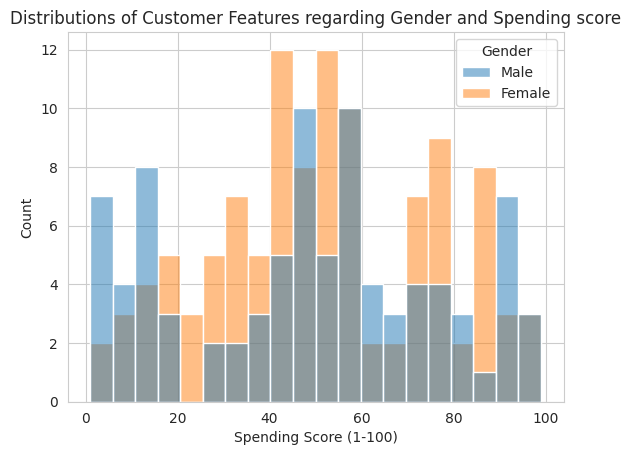

In [ ]:
# Univariate Analysis with Gender and Spending score

fig = sns.histplot( data=df, x='Spending Score (1-100)', bins=20, hue='Gender').set_title('Distributions of Customer Features regarding Gender and Spending score')

plt.show()

In [ ]:
d = df['Gender'].value_counts()
print(d['Male'], d['Female'])

88 112


In [ ]:
k = ['Gender','Spending Score (1-100)']
df[k].describe()

,Spending Score (1-100)
count,200.000000
mean,50.200000
std,25.823522
min,1.000000
25%,34.750000
50%,50.000000
75%,73.000000
max,99.000000


### Insights:
- We observe from the given dataset more number of Females has more spending score.
- The overall spending score does not depend on the gender.

### 2.  **Apply Feature Engineering for Clustering:**

In [ ]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [ ]:
new_df = df.copy()

#Change gender to male 0 or female as 1
new_df['Gender'] = new_df['Gender'].map({'Male':0, 'Female':1})

# Income spend ratio
new_df['Income_spend_ratio'] = new_df['Annual Income (k$)']/new_df['Spending Score (1-100)']

def age_cate(age):
  if age < 40: return 0 # Young
  elif age < 60: return 1 # MIddle
  else: return 2 # Old

new_df['age_cat'] = new_df['Age'].apply(age_cate)

# Customer average score weighted towards income
income_normalized = (new_df['Annual Income (k$)'] - new_df['Annual Income (k$)'].min()) / (new_df['Annual Income (k$)'].max() - new_df['Annual Income (k$)'].min())
spending_normalized = (new_df['Spending Score (1-100)'] - new_df['Spending Score (1-100)'].min()) / (new_df['Spending Score (1-100)'].max() - new_df['Spending Score (1-100)'].min())

new_df['Customer_average_Score'] = 0.6 * income_normalized + 0.4 * spending_normalized

new_df

,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_spend_ratio,age_cat,Customer_average_Score
0,0,19,15,39,0.384615,0,0.155102
1,0,21,15,81,0.185185,0,0.326531
2,1,20,16,6,2.666667,0,0.025326
3,1,23,16,77,0.207792,0,0.315122
4,1,31,17,40,0.425000,0,0.169020
...,...,...,...,...,...,...,...
195,1,35,120,79,1.518987,0,0.834761
196,1,45,126,28,4.500000,1,0.656106
197,0,32,126,74,1.702703,0,0.843861
198,0,32,137,18,7.611111,0,0.669388


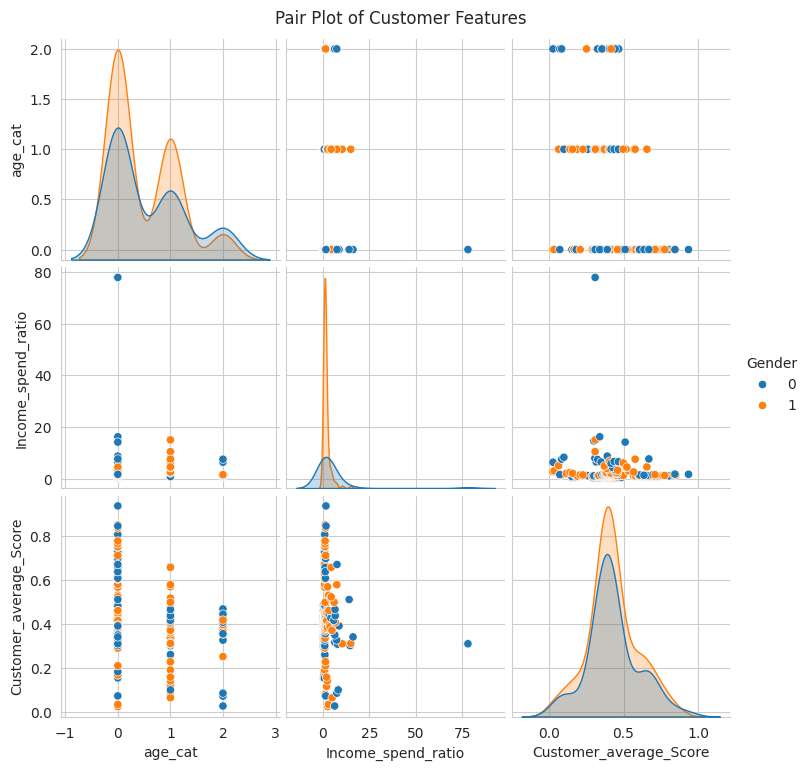

In [ ]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(new_df, vars=['age_cat', 'Income_spend_ratio', 'Customer_average_Score'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

### Insights:
- We observe the cluster in **Income_spend_ratio and Customer_average_score**

In [ ]:
# Visualization
fig = px.scatter_3d(new_df,
                    x='Customer_average_Score',
                    y='Income_spend_ratio',
                    z='age_cat',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()


### Model Based on age catogery and Customer average score

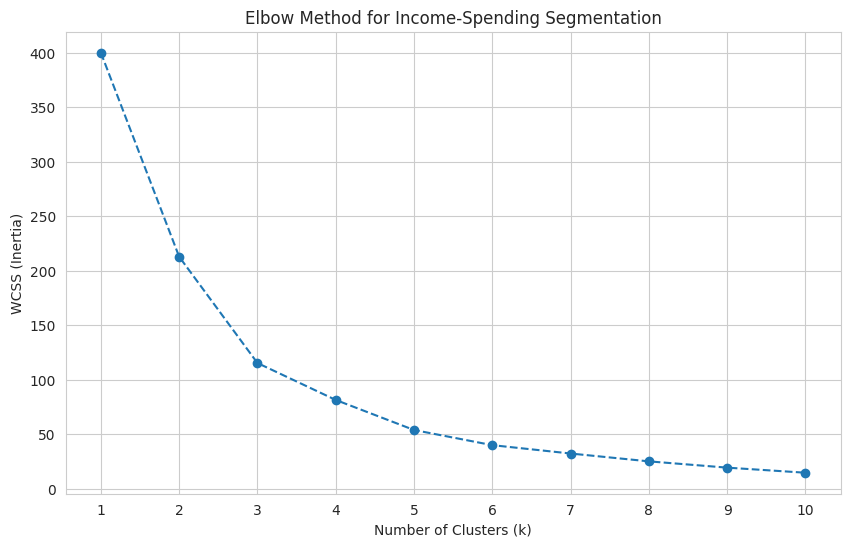

In [ ]:
# Elbow model for age_cat and Customer_average_Score

# 1. Select and scale the features
X1 = new_df[['age_cat', 'Customer_average_Score']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

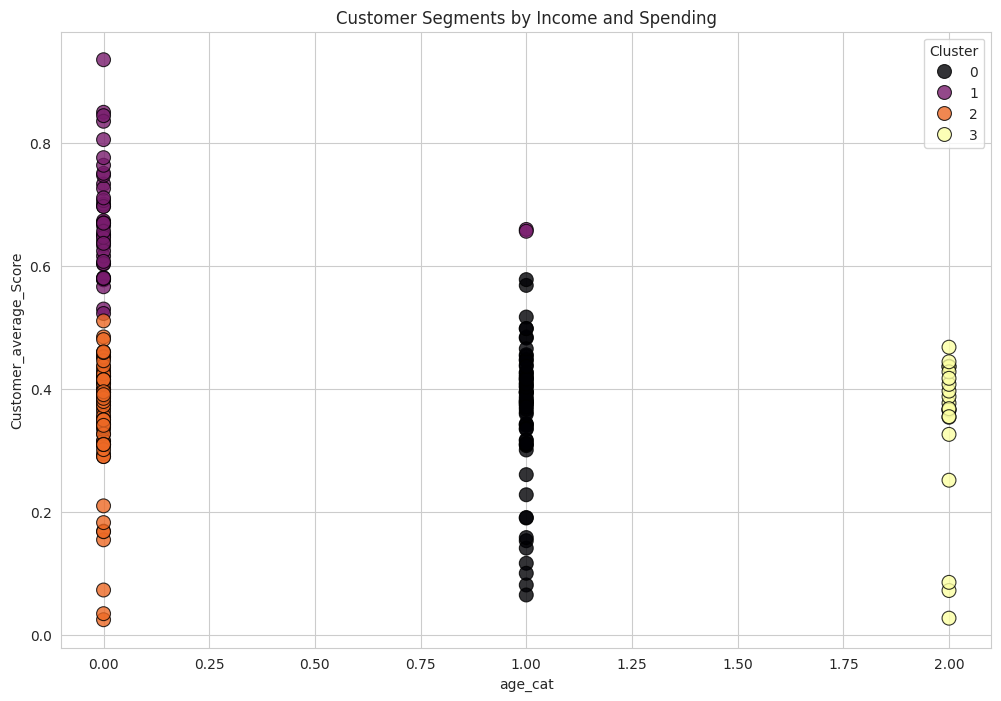

In [ ]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
new_df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

# Visualizing and Interpreting the
plt.figure(figsize=(12, 8))
sns.scatterplot(data=new_df, x='age_cat', y='Customer_average_Score',
                hue='Income_Cluster', palette='inferno', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Quantitative Persona Analysis
cluster_profiles1 = new_df.groupby('Income_Cluster')[['age_cat', 'Customer_average_Score', 'Income_spend_ratio']].mean().round(2)
cluster_profiles1['Size'] = new_df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,age_cat,Customer_average_Score,Income_spend_ratio,Size
Income_Cluster,,,,
0,1.00,0.36,2.90,62
1,0.05,0.67,1.43,43
2,0.00,0.36,3.87,75
3,2.00,0.34,1.70,20


### Insights:
- Income_Cluster 0 : We have Middle aged people they spend less compared to others.
- Income_Cluster 1 : We have Young aged people they spend high compared to others.
- Income_Cluster 2 : We have Young aged people spend less compared to others
- Income_Cluster 3 : We have Old aged people spend less compared to others